In [1]:
# modelagem e dados
import torch
from torch import nn, optim

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt

# operações de imagem
import cv2

# outros
import os
import numpy as np
from tqdm import tqdm

In [2]:
from model.model_up_deconv import SegNet
from dataset.dataloader_sun_rgbd import train_loader, val_loader, test_loader


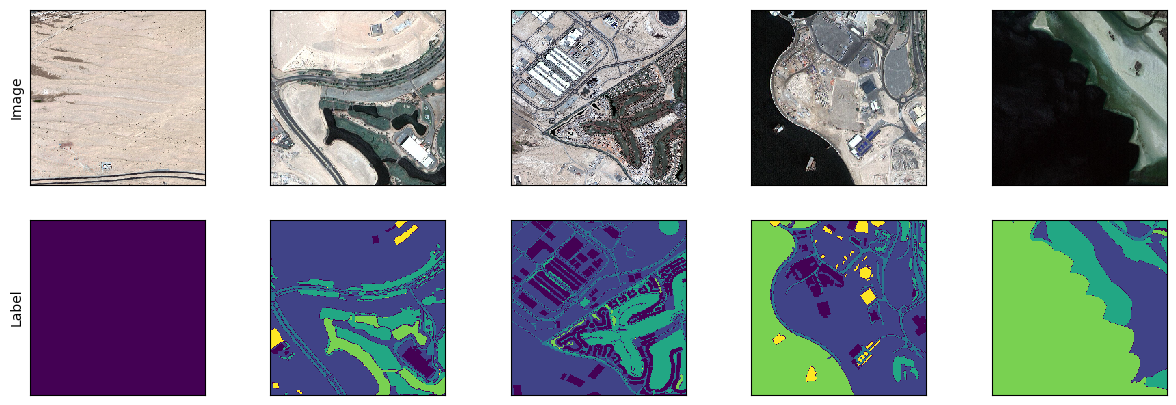

In [3]:
w = 5
fig, ax = plt.subplots(2, w, figsize=(15, 5))

ax[0][0].set_ylabel("Image")
ax[1][0].set_ylabel("Label")

for j in range(w):
    instances, targets = next(iter(train_loader))
    ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
model = SegNet(output_size=6).to(device)
# model.load_state_dict(torch.load(r"model\weights\best.zip"))
summary(SegNet().to(device), (3, 224, 224), 1, device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
       BatchNorm2d-3          [1, 64, 224, 224]             128
            Conv2d-4          [1, 64, 224, 224]          36,928
              ReLU-5          [1, 64, 224, 224]               0
       BatchNorm2d-6          [1, 64, 224, 224]             128
         MaxPool2d-7          [1, 64, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]          73,856
              ReLU-9         [1, 128, 112, 112]               0
      BatchNorm2d-10         [1, 128, 112, 112]             256
           Conv2d-11         [1, 128, 112, 112]         147,584
             ReLU-12         [1, 128, 112, 112]               0
      BatchNorm2d-13         [1, 128, 112, 112]             256
        MaxPool2d-14           [1, 128,

In [6]:
train_losses = list()
valid_losses = list()

In [7]:
EPOCHS = 500
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [8]:
def train_step(model, loader, loss_fn, optimizer, device) -> float:
  train_loss = 0
  for X, Y in loader:
    y_pred = model(X.to(device))
    loss = loss_fn(y_pred, Y.to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  return train_loss / len(loader)


def validation_step(model, loader, loss_fn, device) -> float:
  loss = 0
  with torch.no_grad():
    for X, Y in loader:
      y_pred = model(X.to(device))
      loss += loss_fn(y_pred, Y.to(device)).item()
  return loss / len(loader)

In [9]:
from tqdm import tqdm
from copy import deepcopy

def train_model():
  for epoch in tqdm(range(EPOCHS)):
    train_losses.append(train_step(model, train_loader, loss_fn, optimizer, device))
    valid_losses.append(validation_step(model, val_loader, loss_fn, device))
    if valid_losses[-1] == min(valid_losses):
      best_model = deepcopy(model)
    print("\fLoss: {}\n".format(valid_losses[-1]))
  return best_model

In [10]:
best_model = train_model()

  0%|          | 1/500 [00:04<39:17,  4.72s/it]

Loss: 1.3037604093551636



  0%|          | 2/500 [00:09<38:11,  4.60s/it]

Loss: 1.2794901132583618



  1%|          | 3/500 [00:13<37:48,  4.56s/it]

Loss: 1.2325079441070557



  1%|          | 4/500 [00:18<37:37,  4.55s/it]

Loss: 1.2547262907028198



  1%|          | 5/500 [00:22<37:29,  4.54s/it]

Loss: 1.2492188215255737



  1%|          | 6/500 [00:27<37:23,  4.54s/it]

Loss: 1.2620357275009155



  1%|▏         | 7/500 [00:31<37:16,  4.54s/it]

Loss: 1.2478477954864502



  2%|▏         | 8/500 [00:36<37:11,  4.53s/it]

Loss: 1.2545973062515259



  2%|▏         | 9/500 [00:40<37:06,  4.53s/it]

Loss: 1.253558874130249



  2%|▏         | 10/500 [00:45<37:02,  4.54s/it]

Loss: 1.241070032119751



  2%|▏         | 11/500 [00:50<37:00,  4.54s/it]

Loss: 1.2314953804016113



  2%|▏         | 12/500 [00:54<36:57,  4.54s/it]

Loss: 1.231845498085022



  3%|▎         | 13/500 [00:59<36:53,  4.54s/it]

Loss: 1.2260068655014038



  3%|▎         | 14/500 [01:03<36:48,  4.54s/it]

Loss: 1.2304887771606445



  3%|▎         | 15/500 [01:08<36:45,  4.55s/it]

Loss: 1.227763056755066



  3%|▎         | 16/500 [01:12<36:45,  4.56s/it]

Loss: 1.2253938913345337



  3%|▎         | 17/500 [01:17<36:40,  4.56s/it]

Loss: 1.2279258966445923



  4%|▎         | 18/500 [01:21<36:33,  4.55s/it]

Loss: 1.2319773435592651



  4%|▍         | 19/500 [01:26<36:28,  4.55s/it]

Loss: 1.2365106344223022



  4%|▍         | 20/500 [01:30<36:22,  4.55s/it]

Loss: 1.235854148864746



  4%|▍         | 21/500 [01:35<36:17,  4.55s/it]

Loss: 1.2319568395614624



  4%|▍         | 22/500 [01:40<36:12,  4.55s/it]

Loss: 1.2287794351577759



  5%|▍         | 23/500 [01:44<36:07,  4.54s/it]

Loss: 1.2328897714614868



  5%|▍         | 24/500 [01:49<36:03,  4.54s/it]

Loss: 1.2316328287124634



  5%|▌         | 25/500 [01:53<36:06,  4.56s/it]

Loss: 1.2331422567367554



  5%|▌         | 26/500 [01:58<35:59,  4.56s/it]

Loss: 1.2492551803588867



  5%|▌         | 27/500 [02:02<35:59,  4.57s/it]

Loss: 1.2411097288131714



  6%|▌         | 28/500 [02:07<35:55,  4.57s/it]

Loss: 1.2186580896377563



  6%|▌         | 29/500 [02:12<35:49,  4.56s/it]

Loss: 1.2186774015426636



  6%|▌         | 30/500 [02:16<35:45,  4.56s/it]

Loss: 1.2181241512298584



  6%|▌         | 31/500 [02:21<35:40,  4.56s/it]

Loss: 1.2182475328445435



  6%|▋         | 32/500 [02:25<35:36,  4.56s/it]

Loss: 1.2170639038085938



  7%|▋         | 33/500 [02:30<35:30,  4.56s/it]

Loss: 1.2318891286849976



  7%|▋         | 34/500 [02:34<35:26,  4.56s/it]

Loss: 1.2383426427841187



  7%|▋         | 35/500 [02:39<35:23,  4.57s/it]

Loss: 1.2302004098892212



  7%|▋         | 36/500 [02:43<35:15,  4.56s/it]

Loss: 1.2204746007919312



  7%|▋         | 37/500 [02:48<35:13,  4.56s/it]

Loss: 1.2206355333328247



  8%|▊         | 38/500 [02:53<35:04,  4.56s/it]

Loss: 1.2201626300811768



  8%|▊         | 39/500 [02:57<35:03,  4.56s/it]

Loss: 1.2200459241867065



  8%|▊         | 40/500 [03:02<34:56,  4.56s/it]

Loss: 1.222969651222229



  8%|▊         | 41/500 [03:06<34:48,  4.55s/it]

Loss: 1.2379345893859863



  8%|▊         | 42/500 [03:11<34:41,  4.54s/it]

Loss: 1.257967233657837



  9%|▊         | 43/500 [03:15<34:36,  4.54s/it]

Loss: 1.264198899269104



  9%|▉         | 44/500 [03:20<34:32,  4.55s/it]

Loss: 1.2617177963256836



  9%|▉         | 45/500 [03:24<34:27,  4.54s/it]

Loss: 1.2545868158340454



  9%|▉         | 46/500 [03:29<34:22,  4.54s/it]

Loss: 1.241808295249939



  9%|▉         | 47/500 [03:33<34:17,  4.54s/it]

Loss: 1.221375584602356



 10%|▉         | 48/500 [03:38<34:16,  4.55s/it]

Loss: 1.2148302793502808



 10%|▉         | 49/500 [03:43<34:07,  4.54s/it]

Loss: 1.2151888608932495



 10%|█         | 50/500 [03:47<33:58,  4.53s/it]

Loss: 1.2109266519546509



 10%|█         | 51/500 [03:52<33:52,  4.53s/it]

Loss: 1.2255921363830566



 10%|█         | 52/500 [03:56<33:51,  4.53s/it]

Loss: 1.2515782117843628



 11%|█         | 53/500 [04:01<33:49,  4.54s/it]

Loss: 1.2586464881896973



 11%|█         | 54/500 [04:05<33:37,  4.52s/it]

Loss: 1.2335339784622192



 11%|█         | 55/500 [04:10<33:21,  4.50s/it]

Loss: 1.2198245525360107



 11%|█         | 56/500 [04:14<33:22,  4.51s/it]

Loss: 1.2181024551391602



 11%|█▏        | 57/500 [04:19<33:23,  4.52s/it]

Loss: 1.2173429727554321



 12%|█▏        | 58/500 [04:23<33:20,  4.53s/it]

Loss: 1.2179195880889893



 12%|█▏        | 59/500 [04:28<33:18,  4.53s/it]

Loss: 1.225650429725647



 12%|█▏        | 60/500 [04:32<33:14,  4.53s/it]

Loss: 1.2485369443893433



 12%|█▏        | 61/500 [04:37<33:12,  4.54s/it]

Loss: 1.2614754438400269



 12%|█▏        | 62/500 [04:41<33:09,  4.54s/it]

Loss: 1.250390887260437



 13%|█▎        | 63/500 [04:46<33:05,  4.54s/it]

Loss: 1.225781798362732



 13%|█▎        | 64/500 [04:51<33:01,  4.55s/it]

Loss: 1.2190912961959839



 13%|█▎        | 65/500 [04:55<32:57,  4.55s/it]

Loss: 1.2167388200759888



 13%|█▎        | 66/500 [05:00<32:53,  4.55s/it]

Loss: 1.2159286737442017



 13%|█▎        | 67/500 [05:04<32:48,  4.55s/it]

Loss: 1.2183442115783691



 14%|█▎        | 68/500 [05:09<32:45,  4.55s/it]

Loss: 1.2259725332260132



 14%|█▍        | 69/500 [05:13<32:41,  4.55s/it]

Loss: 1.232530951499939



 14%|█▍        | 70/500 [05:18<32:37,  4.55s/it]

Loss: 1.2286832332611084



 14%|█▍        | 71/500 [05:22<32:33,  4.55s/it]

Loss: 1.2160730361938477



 14%|█▍        | 72/500 [05:27<32:29,  4.56s/it]

Loss: 1.2098970413208008



 15%|█▍        | 73/500 [05:31<32:25,  4.56s/it]

Loss: 1.2070269584655762



 15%|█▍        | 74/500 [05:36<32:20,  4.56s/it]

Loss: 1.2074861526489258



 15%|█▌        | 75/500 [05:41<32:16,  4.56s/it]

Loss: 1.2120590209960938



 15%|█▌        | 76/500 [05:45<32:11,  4.56s/it]

Loss: 1.2232847213745117



 15%|█▌        | 77/500 [05:50<32:08,  4.56s/it]

Loss: 1.2298554182052612



 16%|█▌        | 78/500 [05:54<32:03,  4.56s/it]

Loss: 1.2221393585205078



 16%|█▌        | 79/500 [05:59<31:59,  4.56s/it]

Loss: 1.2045310735702515



 16%|█▌        | 80/500 [06:03<31:53,  4.56s/it]

Loss: 1.2045472860336304



 16%|█▌        | 81/500 [06:08<31:49,  4.56s/it]

Loss: 1.2019660472869873



 16%|█▋        | 82/500 [06:13<31:45,  4.56s/it]

Loss: 1.2017990350723267



 17%|█▋        | 83/500 [06:17<31:40,  4.56s/it]

Loss: 1.219411015510559



 17%|█▋        | 84/500 [06:22<31:35,  4.56s/it]

Loss: 1.23602294921875



 17%|█▋        | 85/500 [06:26<31:30,  4.56s/it]

Loss: 1.2380799055099487



 17%|█▋        | 86/500 [06:31<31:25,  4.55s/it]

Loss: 1.221222162246704



 17%|█▋        | 87/500 [06:35<31:20,  4.55s/it]

Loss: 1.2064279317855835



 18%|█▊        | 88/500 [06:40<31:15,  4.55s/it]

Loss: 1.2024329900741577



 18%|█▊        | 89/500 [06:44<31:09,  4.55s/it]

Loss: 1.2018635272979736



 18%|█▊        | 90/500 [06:49<31:04,  4.55s/it]

Loss: 1.204882025718689



 18%|█▊        | 91/500 [06:53<30:59,  4.55s/it]

Loss: 1.2160953283309937



 18%|█▊        | 92/500 [06:58<30:55,  4.55s/it]

Loss: 1.2275965213775635



 19%|█▊        | 93/500 [07:03<30:51,  4.55s/it]

Loss: 1.2314637899398804



 19%|█▉        | 94/500 [07:07<30:48,  4.55s/it]

Loss: 1.2249726057052612



 19%|█▉        | 95/500 [07:12<30:43,  4.55s/it]

Loss: 1.2193846702575684



 19%|█▉        | 96/500 [07:16<30:40,  4.55s/it]

Loss: 1.2146908044815063



 19%|█▉        | 97/500 [07:21<30:34,  4.55s/it]

Loss: 1.2105647325515747



 20%|█▉        | 98/500 [07:25<30:30,  4.55s/it]

Loss: 1.2070187330245972



 20%|█▉        | 99/500 [07:30<30:25,  4.55s/it]

Loss: 1.2035192251205444



 20%|██        | 100/500 [07:34<30:20,  4.55s/it]

Loss: 1.2042515277862549



 20%|██        | 101/500 [07:39<30:16,  4.55s/it]

Loss: 1.2106882333755493



 20%|██        | 102/500 [07:44<30:11,  4.55s/it]

Loss: 1.2208665609359741



 21%|██        | 103/500 [07:48<30:07,  4.55s/it]

Loss: 1.225953221321106



 21%|██        | 104/500 [07:53<30:02,  4.55s/it]

Loss: 1.2206743955612183



 21%|██        | 105/500 [07:57<29:58,  4.55s/it]

Loss: 1.2109930515289307



 21%|██        | 106/500 [08:02<29:53,  4.55s/it]

Loss: 1.2051143646240234



 21%|██▏       | 107/500 [08:06<29:49,  4.55s/it]

Loss: 1.2046358585357666



 22%|██▏       | 108/500 [08:11<29:45,  4.55s/it]

Loss: 1.2071466445922852



 22%|██▏       | 109/500 [08:15<29:40,  4.55s/it]

Loss: 1.2103992700576782



 22%|██▏       | 110/500 [08:20<29:35,  4.55s/it]

Loss: 1.2147505283355713



 22%|██▏       | 111/500 [08:25<29:31,  4.55s/it]

Loss: 1.2172842025756836



 22%|██▏       | 112/500 [08:29<29:26,  4.55s/it]

Loss: 1.2210477590560913



 23%|██▎       | 113/500 [08:34<29:21,  4.55s/it]

Loss: 1.222338080406189



 23%|██▎       | 114/500 [08:38<29:16,  4.55s/it]

Loss: 1.2207002639770508



 23%|██▎       | 115/500 [08:43<29:11,  4.55s/it]

Loss: 1.2168118953704834



 23%|██▎       | 116/500 [08:47<29:06,  4.55s/it]

Loss: 1.2105191946029663



 23%|██▎       | 117/500 [08:52<29:04,  4.56s/it]

Loss: 1.2063430547714233



 24%|██▎       | 118/500 [08:56<29:02,  4.56s/it]

Loss: 1.2049559354782104



 24%|██▍       | 119/500 [09:01<28:59,  4.56s/it]

Loss: 1.2057297229766846



 24%|██▍       | 120/500 [09:06<28:55,  4.57s/it]

Loss: 1.2081135511398315



 24%|██▍       | 121/500 [09:10<28:52,  4.57s/it]

Loss: 1.2133878469467163



 24%|██▍       | 122/500 [09:15<28:48,  4.57s/it]

Loss: 1.2243998050689697



 25%|██▍       | 123/500 [09:19<28:45,  4.58s/it]

Loss: 1.228655219078064



 25%|██▍       | 124/500 [09:24<28:40,  4.58s/it]

Loss: 1.2303853034973145



 25%|██▌       | 125/500 [09:28<28:36,  4.58s/it]

Loss: 1.23089599609375



 25%|██▌       | 126/500 [09:33<28:31,  4.58s/it]

Loss: 1.2305097579956055



 25%|██▌       | 127/500 [09:38<28:28,  4.58s/it]

Loss: 1.2296947240829468



 26%|██▌       | 128/500 [09:42<28:24,  4.58s/it]

Loss: 1.2284294366836548



 26%|██▌       | 129/500 [09:47<28:19,  4.58s/it]

Loss: 1.226887583732605



 26%|██▌       | 130/500 [09:51<28:14,  4.58s/it]

Loss: 1.2260226011276245



 26%|██▌       | 131/500 [09:56<28:09,  4.58s/it]

Loss: 1.2253268957138062



 26%|██▋       | 132/500 [10:01<28:05,  4.58s/it]

Loss: 1.2248027324676514



 27%|██▋       | 133/500 [10:05<28:01,  4.58s/it]

Loss: 1.2237986326217651



 27%|██▋       | 134/500 [10:10<27:56,  4.58s/it]

Loss: 1.2234992980957031



 27%|██▋       | 135/500 [10:14<27:52,  4.58s/it]

Loss: 1.2239540815353394



 27%|██▋       | 136/500 [10:19<27:47,  4.58s/it]

Loss: 1.2247313261032104



 27%|██▋       | 137/500 [10:23<27:43,  4.58s/it]

Loss: 1.2249573469161987



 28%|██▊       | 138/500 [10:28<27:38,  4.58s/it]

Loss: 1.2251750230789185



 28%|██▊       | 139/500 [10:33<27:34,  4.58s/it]

Loss: 1.228013038635254



 28%|██▊       | 140/500 [10:37<27:29,  4.58s/it]

Loss: 1.2313809394836426



 28%|██▊       | 141/500 [10:42<27:24,  4.58s/it]

Loss: 1.2299082279205322



 28%|██▊       | 142/500 [10:46<27:19,  4.58s/it]

Loss: 1.2270368337631226



 29%|██▊       | 143/500 [10:51<27:15,  4.58s/it]

Loss: 1.2263544797897339



 29%|██▉       | 144/500 [10:56<27:10,  4.58s/it]

Loss: 1.2276700735092163



 29%|██▉       | 145/500 [11:00<27:05,  4.58s/it]

Loss: 1.2294124364852905



 29%|██▉       | 146/500 [11:05<27:00,  4.58s/it]

Loss: 1.230961799621582



 29%|██▉       | 147/500 [11:09<26:56,  4.58s/it]

Loss: 1.2329134941101074



 30%|██▉       | 148/500 [11:14<26:52,  4.58s/it]

Loss: 1.2345030307769775



 30%|██▉       | 149/500 [11:18<26:48,  4.58s/it]

Loss: 1.233333706855774



 30%|███       | 150/500 [11:23<26:43,  4.58s/it]

Loss: 1.2284148931503296



 30%|███       | 151/500 [11:28<26:38,  4.58s/it]

Loss: 1.2239277362823486



 30%|███       | 152/500 [11:32<26:33,  4.58s/it]

Loss: 1.2217286825180054



 31%|███       | 153/500 [11:37<26:28,  4.58s/it]

Loss: 1.220928430557251



 31%|███       | 154/500 [11:41<26:23,  4.58s/it]

Loss: 1.2218149900436401



 31%|███       | 155/500 [11:46<26:19,  4.58s/it]

Loss: 1.2243092060089111



 31%|███       | 156/500 [11:50<26:14,  4.58s/it]

Loss: 1.2266511917114258



 31%|███▏      | 157/500 [11:55<26:10,  4.58s/it]

Loss: 1.2258574962615967



 32%|███▏      | 158/500 [12:00<26:05,  4.58s/it]

Loss: 1.2238349914550781



 32%|███▏      | 159/500 [12:04<26:01,  4.58s/it]

Loss: 1.2228666543960571



 32%|███▏      | 160/500 [12:09<25:57,  4.58s/it]

Loss: 1.2236733436584473



 32%|███▏      | 161/500 [12:13<25:53,  4.58s/it]

Loss: 1.2258132696151733



 32%|███▏      | 162/500 [12:18<25:48,  4.58s/it]

Loss: 1.2292855978012085



 33%|███▎      | 163/500 [12:23<25:44,  4.58s/it]

Loss: 1.2334568500518799



 33%|███▎      | 164/500 [12:27<25:39,  4.58s/it]

Loss: 1.2365878820419312



 33%|███▎      | 165/500 [12:32<25:35,  4.58s/it]

Loss: 1.2388712167739868



 33%|███▎      | 166/500 [12:36<25:30,  4.58s/it]

Loss: 1.238655924797058



 33%|███▎      | 167/500 [12:41<25:25,  4.58s/it]

Loss: 1.2361334562301636



 34%|███▎      | 168/500 [12:45<25:20,  4.58s/it]

Loss: 1.2314363718032837



 34%|███▍      | 169/500 [12:50<25:15,  4.58s/it]

Loss: 1.2275891304016113



 34%|███▍      | 170/500 [12:55<25:10,  4.58s/it]

Loss: 1.2258667945861816



 34%|███▍      | 171/500 [12:59<25:06,  4.58s/it]

Loss: 1.2267128229141235



 34%|███▍      | 172/500 [13:04<25:01,  4.58s/it]

Loss: 1.2296054363250732



 35%|███▍      | 173/500 [13:08<24:57,  4.58s/it]

Loss: 1.2337675094604492



 35%|███▍      | 174/500 [13:13<24:52,  4.58s/it]

Loss: 1.2377731800079346



 35%|███▌      | 175/500 [13:17<24:47,  4.58s/it]

Loss: 1.2388113737106323



 35%|███▌      | 176/500 [13:22<24:43,  4.58s/it]

Loss: 1.2366935014724731



 35%|███▌      | 177/500 [13:27<24:38,  4.58s/it]

Loss: 1.2336252927780151



 36%|███▌      | 178/500 [13:31<24:34,  4.58s/it]

Loss: 1.2309541702270508



 36%|███▌      | 179/500 [13:36<24:29,  4.58s/it]

Loss: 1.229357361793518



 36%|███▌      | 180/500 [13:40<24:25,  4.58s/it]

Loss: 1.2292137145996094



 36%|███▌      | 181/500 [13:45<24:21,  4.58s/it]

Loss: 1.2296515703201294



 36%|███▋      | 182/500 [13:50<24:16,  4.58s/it]

Loss: 1.2303813695907593



 37%|███▋      | 183/500 [13:54<24:12,  4.58s/it]

Loss: 1.2305601835250854



 37%|███▋      | 184/500 [13:59<24:07,  4.58s/it]

Loss: 1.2289655208587646



 37%|███▋      | 185/500 [14:03<24:02,  4.58s/it]

Loss: 1.2276605367660522



 37%|███▋      | 186/500 [14:08<23:58,  4.58s/it]

Loss: 1.2271205186843872



 37%|███▋      | 187/500 [14:12<23:53,  4.58s/it]

Loss: 1.2259691953659058



 38%|███▊      | 188/500 [14:17<23:48,  4.58s/it]

Loss: 1.2244526147842407



 38%|███▊      | 189/500 [14:22<23:44,  4.58s/it]

Loss: 1.2228821516036987



 38%|███▊      | 190/500 [14:26<23:39,  4.58s/it]

Loss: 1.221770167350769



 38%|███▊      | 191/500 [14:31<23:35,  4.58s/it]

Loss: 1.2217187881469727



 38%|███▊      | 192/500 [14:35<23:30,  4.58s/it]

Loss: 1.2224602699279785



 39%|███▊      | 193/500 [14:40<23:25,  4.58s/it]

Loss: 1.2213869094848633



 39%|███▉      | 194/500 [14:44<23:20,  4.58s/it]

Loss: 1.2182753086090088



 39%|███▉      | 195/500 [14:49<23:15,  4.58s/it]

Loss: 1.215431809425354



 39%|███▉      | 196/500 [14:54<23:11,  4.58s/it]

Loss: 1.2137774229049683



 39%|███▉      | 197/500 [14:58<23:06,  4.58s/it]

Loss: 1.2146729230880737



 40%|███▉      | 198/500 [15:03<23:02,  4.58s/it]

Loss: 1.217995285987854



 40%|███▉      | 199/500 [15:07<22:58,  4.58s/it]

Loss: 1.2225033044815063



 40%|████      | 200/500 [15:12<22:53,  4.58s/it]

Loss: 1.226974368095398



 40%|████      | 201/500 [15:17<22:48,  4.58s/it]

Loss: 1.2293368577957153



 40%|████      | 202/500 [15:21<22:43,  4.58s/it]

Loss: 1.2293322086334229



 41%|████      | 203/500 [15:26<22:39,  4.58s/it]

Loss: 1.2277683019638062



 41%|████      | 204/500 [15:30<22:35,  4.58s/it]

Loss: 1.2255795001983643



 41%|████      | 205/500 [15:35<22:30,  4.58s/it]

Loss: 1.2227003574371338



 41%|████      | 206/500 [15:39<22:26,  4.58s/it]

Loss: 1.2197227478027344



 41%|████▏     | 207/500 [15:44<22:21,  4.58s/it]

Loss: 1.2178667783737183



 42%|████▏     | 208/500 [15:49<22:17,  4.58s/it]

Loss: 1.217410922050476



 42%|████▏     | 209/500 [15:53<22:12,  4.58s/it]

Loss: 1.2184503078460693



 42%|████▏     | 210/500 [15:58<22:08,  4.58s/it]

Loss: 1.2208014726638794



 42%|████▏     | 211/500 [16:02<22:02,  4.58s/it]

Loss: 1.2231253385543823



 42%|████▏     | 212/500 [16:07<21:58,  4.58s/it]

Loss: 1.2244585752487183



 43%|████▎     | 213/500 [16:11<21:54,  4.58s/it]

Loss: 1.2233952283859253



 43%|████▎     | 214/500 [16:16<21:49,  4.58s/it]

Loss: 1.2198868989944458



 43%|████▎     | 215/500 [16:21<21:45,  4.58s/it]

Loss: 1.2153242826461792



 43%|████▎     | 216/500 [16:25<21:40,  4.58s/it]

Loss: 1.2135823965072632



 43%|████▎     | 217/500 [16:30<21:36,  4.58s/it]

Loss: 1.2130975723266602



 44%|████▎     | 218/500 [16:34<21:31,  4.58s/it]

Loss: 1.2137125730514526



 44%|████▍     | 219/500 [16:39<21:26,  4.58s/it]

Loss: 1.215086817741394



 44%|████▍     | 220/500 [16:44<21:21,  4.58s/it]

Loss: 1.2163479328155518



 44%|████▍     | 221/500 [16:48<21:17,  4.58s/it]

Loss: 1.2179654836654663



 44%|████▍     | 222/500 [16:53<21:12,  4.58s/it]

Loss: 1.2190438508987427



 45%|████▍     | 223/500 [16:57<21:07,  4.58s/it]

Loss: 1.2191814184188843



 45%|████▍     | 224/500 [17:02<21:02,  4.58s/it]

Loss: 1.2194875478744507



 45%|████▌     | 225/500 [17:06<20:58,  4.58s/it]

Loss: 1.2186380624771118



 45%|████▌     | 226/500 [17:11<20:54,  4.58s/it]

Loss: 1.2173771858215332



 45%|████▌     | 227/500 [17:16<20:49,  4.58s/it]

Loss: 1.2168642282485962



 46%|████▌     | 228/500 [17:20<20:45,  4.58s/it]

Loss: 1.2165673971176147



 46%|████▌     | 229/500 [17:25<20:40,  4.58s/it]

Loss: 1.2168091535568237



 46%|████▌     | 230/500 [17:29<20:36,  4.58s/it]

Loss: 1.2172149419784546



 46%|████▌     | 231/500 [17:34<20:32,  4.58s/it]

Loss: 1.2167662382125854



 46%|████▋     | 232/500 [17:38<20:27,  4.58s/it]

Loss: 1.2143656015396118



 47%|████▋     | 233/500 [17:43<20:23,  4.58s/it]

Loss: 1.2102751731872559



 47%|████▋     | 234/500 [17:48<20:18,  4.58s/it]

Loss: 1.2064778804779053



 47%|████▋     | 235/500 [17:52<20:13,  4.58s/it]

Loss: 1.2035248279571533



 47%|████▋     | 236/500 [17:57<20:08,  4.58s/it]

Loss: 1.2018083333969116



 47%|████▋     | 237/500 [18:01<20:04,  4.58s/it]

Loss: 1.2014439105987549



 48%|████▊     | 238/500 [18:06<20:00,  4.58s/it]

Loss: 1.2029074430465698



 48%|████▊     | 239/500 [18:11<19:55,  4.58s/it]

Loss: 1.2071113586425781



 48%|████▊     | 240/500 [18:15<19:50,  4.58s/it]

Loss: 1.2118892669677734



 48%|████▊     | 241/500 [18:20<19:46,  4.58s/it]

Loss: 1.2154645919799805



 48%|████▊     | 242/500 [18:24<19:41,  4.58s/it]

Loss: 1.2173856496810913



 49%|████▊     | 243/500 [18:29<19:36,  4.58s/it]

Loss: 1.2176779508590698



 49%|████▉     | 244/500 [18:33<19:32,  4.58s/it]

Loss: 1.2165462970733643



 49%|████▉     | 245/500 [18:38<19:28,  4.58s/it]

Loss: 1.214250087738037



 49%|████▉     | 246/500 [18:43<19:23,  4.58s/it]

Loss: 1.2118712663650513



 49%|████▉     | 247/500 [18:47<19:18,  4.58s/it]

Loss: 1.2103931903839111



 50%|████▉     | 248/500 [18:52<19:13,  4.58s/it]

Loss: 1.210184931755066



 50%|████▉     | 249/500 [18:56<19:09,  4.58s/it]

Loss: 1.2098356485366821



 50%|█████     | 250/500 [19:01<19:02,  4.57s/it]

Loss: 1.2112436294555664



 50%|█████     | 251/500 [19:05<18:56,  4.56s/it]

Loss: 1.2131775617599487



 50%|█████     | 252/500 [19:10<18:51,  4.56s/it]

Loss: 1.2141364812850952



 51%|█████     | 253/500 [19:15<18:45,  4.55s/it]

Loss: 1.2142680883407593



 51%|█████     | 254/500 [19:19<18:38,  4.55s/it]

Loss: 1.2138251066207886



 51%|█████     | 255/500 [19:24<18:33,  4.54s/it]

Loss: 1.2138807773590088



 51%|█████     | 256/500 [19:28<18:28,  4.54s/it]

Loss: 1.2145235538482666



 51%|█████▏    | 257/500 [19:33<18:22,  4.54s/it]

Loss: 1.2153677940368652



 52%|█████▏    | 258/500 [19:37<18:18,  4.54s/it]

Loss: 1.2159228324890137



 52%|█████▏    | 259/500 [19:42<18:13,  4.54s/it]

Loss: 1.215958595275879



 52%|█████▏    | 260/500 [19:46<18:08,  4.53s/it]

Loss: 1.2145788669586182



 52%|█████▏    | 261/500 [19:51<18:03,  4.54s/it]

Loss: 1.2121654748916626



 52%|█████▏    | 262/500 [19:55<17:59,  4.54s/it]

Loss: 1.2098640203475952



 53%|█████▎    | 263/500 [20:00<17:55,  4.54s/it]

Loss: 1.2086399793624878



 53%|█████▎    | 264/500 [20:04<17:50,  4.54s/it]

Loss: 1.2094459533691406



 53%|█████▎    | 265/500 [20:09<17:45,  4.53s/it]

Loss: 1.211542010307312



 53%|█████▎    | 266/500 [20:13<17:41,  4.53s/it]

Loss: 1.2116413116455078



 53%|█████▎    | 267/500 [20:18<17:36,  4.53s/it]

Loss: 1.2113418579101562



 54%|█████▎    | 268/500 [20:23<17:31,  4.53s/it]

Loss: 1.2117160558700562



 54%|█████▍    | 269/500 [20:27<17:26,  4.53s/it]

Loss: 1.2120931148529053



 54%|█████▍    | 270/500 [20:32<17:22,  4.53s/it]

Loss: 1.2108982801437378



 54%|█████▍    | 271/500 [20:36<17:17,  4.53s/it]

Loss: 1.2093279361724854



 54%|█████▍    | 272/500 [20:41<17:12,  4.53s/it]

Loss: 1.2087703943252563



 55%|█████▍    | 273/500 [20:45<17:07,  4.53s/it]

Loss: 1.208896279335022



 55%|█████▍    | 274/500 [20:50<17:02,  4.53s/it]

Loss: 1.2081856727600098



 55%|█████▌    | 275/500 [20:54<16:58,  4.53s/it]

Loss: 1.2078503370285034



 55%|█████▌    | 276/500 [20:59<16:53,  4.53s/it]

Loss: 1.2079156637191772



 55%|█████▌    | 277/500 [21:03<16:49,  4.52s/it]

Loss: 1.208365797996521



 56%|█████▌    | 278/500 [21:08<16:44,  4.53s/it]

Loss: 1.2085316181182861



 56%|█████▌    | 279/500 [21:12<16:40,  4.53s/it]

Loss: 1.2069090604782104



 56%|█████▌    | 280/500 [21:17<16:36,  4.53s/it]

Loss: 1.2051295042037964



 56%|█████▌    | 281/500 [21:21<16:31,  4.53s/it]

Loss: 1.204270601272583



 56%|█████▋    | 282/500 [21:26<16:27,  4.53s/it]

Loss: 1.20473313331604



 57%|█████▋    | 283/500 [21:30<16:23,  4.53s/it]

Loss: 1.205909252166748



 57%|█████▋    | 284/500 [21:35<16:18,  4.53s/it]

Loss: 1.2086660861968994



 57%|█████▋    | 285/500 [21:40<16:14,  4.53s/it]

Loss: 1.2121686935424805



 57%|█████▋    | 286/500 [21:44<16:09,  4.53s/it]

Loss: 1.2145137786865234



 57%|█████▋    | 287/500 [21:49<16:04,  4.53s/it]

Loss: 1.215248465538025



 58%|█████▊    | 288/500 [21:53<16:00,  4.53s/it]

Loss: 1.2141273021697998



 58%|█████▊    | 289/500 [21:58<15:55,  4.53s/it]

Loss: 1.2109241485595703



 58%|█████▊    | 290/500 [22:02<15:51,  4.53s/it]

Loss: 1.208343267440796



 58%|█████▊    | 291/500 [22:07<15:46,  4.53s/it]

Loss: 1.2062708139419556



 58%|█████▊    | 292/500 [22:11<15:41,  4.53s/it]

Loss: 1.2043993473052979



 59%|█████▊    | 293/500 [22:16<15:37,  4.53s/it]

Loss: 1.2023372650146484



 59%|█████▉    | 294/500 [22:20<15:33,  4.53s/it]

Loss: 1.2004122734069824



 59%|█████▉    | 295/500 [22:25<15:28,  4.53s/it]

Loss: 1.1990066766738892



 59%|█████▉    | 296/500 [22:29<15:23,  4.53s/it]

Loss: 1.1993786096572876



 59%|█████▉    | 297/500 [22:34<15:19,  4.53s/it]

Loss: 1.2020362615585327



 60%|█████▉    | 298/500 [22:38<15:15,  4.53s/it]

Loss: 1.2049845457077026



 60%|█████▉    | 299/500 [22:43<15:10,  4.53s/it]

Loss: 1.2070121765136719



 60%|██████    | 300/500 [22:47<15:06,  4.53s/it]

Loss: 1.2080318927764893



 60%|██████    | 301/500 [22:52<15:01,  4.53s/it]

Loss: 1.2083854675292969



 60%|██████    | 302/500 [22:57<14:57,  4.53s/it]

Loss: 1.2078419923782349



 61%|██████    | 303/500 [23:01<14:52,  4.53s/it]

Loss: 1.2067047357559204



 61%|██████    | 304/500 [23:06<14:48,  4.53s/it]

Loss: 1.2051565647125244



 61%|██████    | 305/500 [23:10<14:43,  4.53s/it]

Loss: 1.2026922702789307



 61%|██████    | 306/500 [23:15<14:39,  4.53s/it]

Loss: 1.20134437084198



 61%|██████▏   | 307/500 [23:19<14:34,  4.53s/it]

Loss: 1.202150583267212



 62%|██████▏   | 308/500 [23:24<14:29,  4.53s/it]

Loss: 1.204567790031433



 62%|██████▏   | 309/500 [23:28<14:25,  4.53s/it]

Loss: 1.2068120241165161



 62%|██████▏   | 310/500 [23:33<14:20,  4.53s/it]

Loss: 1.20867121219635



 62%|██████▏   | 311/500 [23:37<14:16,  4.53s/it]

Loss: 1.2103465795516968



 62%|██████▏   | 312/500 [23:42<14:11,  4.53s/it]

Loss: 1.211295485496521



 63%|██████▎   | 313/500 [23:46<14:07,  4.53s/it]

Loss: 1.210844874382019



 63%|██████▎   | 314/500 [23:51<14:02,  4.53s/it]

Loss: 1.208467960357666



 63%|██████▎   | 315/500 [23:55<13:58,  4.53s/it]

Loss: 1.204965353012085



 63%|██████▎   | 316/500 [24:00<13:53,  4.53s/it]

Loss: 1.2013291120529175



 63%|██████▎   | 317/500 [24:04<13:49,  4.53s/it]

Loss: 1.1986936330795288



 64%|██████▎   | 318/500 [24:09<13:44,  4.53s/it]

Loss: 1.1976536512374878



 64%|██████▍   | 319/500 [24:14<13:40,  4.53s/it]

Loss: 1.1975306272506714



 64%|██████▍   | 320/500 [24:18<13:35,  4.53s/it]

Loss: 1.1975462436676025



 64%|██████▍   | 321/500 [24:23<13:30,  4.53s/it]

Loss: 1.1975497007369995



 64%|██████▍   | 322/500 [24:27<13:26,  4.53s/it]

Loss: 1.1980373859405518



 65%|██████▍   | 323/500 [24:32<13:21,  4.53s/it]

Loss: 1.1987189054489136



 65%|██████▍   | 324/500 [24:36<13:17,  4.53s/it]

Loss: 1.1998175382614136



 65%|██████▌   | 325/500 [24:41<13:12,  4.53s/it]

Loss: 1.2012814283370972



 65%|██████▌   | 326/500 [24:45<13:07,  4.53s/it]

Loss: 1.2034047842025757



 65%|██████▌   | 327/500 [24:50<13:02,  4.53s/it]

Loss: 1.2054188251495361



 66%|██████▌   | 328/500 [24:54<12:58,  4.53s/it]

Loss: 1.2066929340362549



 66%|██████▌   | 329/500 [24:59<12:53,  4.53s/it]

Loss: 1.2070108652114868



 66%|██████▌   | 330/500 [25:03<12:49,  4.53s/it]

Loss: 1.2057298421859741



 66%|██████▌   | 331/500 [25:08<12:45,  4.53s/it]

Loss: 1.2041515111923218



 66%|██████▋   | 332/500 [25:12<12:40,  4.53s/it]

Loss: 1.2033532857894897



 67%|██████▋   | 333/500 [25:17<12:36,  4.53s/it]

Loss: 1.2027029991149902



 67%|██████▋   | 334/500 [25:21<12:32,  4.53s/it]

Loss: 1.20138680934906



 67%|██████▋   | 335/500 [25:26<12:27,  4.53s/it]

Loss: 1.1989821195602417



 67%|██████▋   | 336/500 [25:31<12:23,  4.53s/it]

Loss: 1.1960891485214233



 67%|██████▋   | 337/500 [25:35<12:18,  4.53s/it]

Loss: 1.1936720609664917



 68%|██████▊   | 338/500 [25:40<12:14,  4.53s/it]

Loss: 1.1940349340438843



 68%|██████▊   | 339/500 [25:44<12:09,  4.53s/it]

Loss: 1.1964176893234253



 68%|██████▊   | 340/500 [25:49<12:05,  4.53s/it]

Loss: 1.1972118616104126



 68%|██████▊   | 341/500 [25:53<12:00,  4.53s/it]

Loss: 1.1961532831192017



 68%|██████▊   | 342/500 [25:58<11:56,  4.53s/it]

Loss: 1.1959635019302368



 69%|██████▊   | 343/500 [26:02<11:51,  4.53s/it]

Loss: 1.198290467262268



 69%|██████▉   | 344/500 [26:07<11:46,  4.53s/it]

Loss: 1.2009062767028809



 69%|██████▉   | 345/500 [26:11<11:42,  4.53s/it]

Loss: 1.20075261592865



 69%|██████▉   | 346/500 [26:16<11:38,  4.53s/it]

Loss: 1.1995733976364136



 69%|██████▉   | 347/500 [26:20<11:33,  4.53s/it]

Loss: 1.2002606391906738



 70%|██████▉   | 348/500 [26:25<11:28,  4.53s/it]

Loss: 1.2027792930603027



 70%|██████▉   | 349/500 [26:29<11:24,  4.53s/it]

Loss: 1.2042814493179321



 70%|███████   | 350/500 [26:34<11:19,  4.53s/it]

Loss: 1.2041306495666504



 70%|███████   | 351/500 [26:39<11:14,  4.53s/it]

Loss: 1.2021445035934448



 70%|███████   | 352/500 [26:43<11:10,  4.53s/it]

Loss: 1.200033187866211



 71%|███████   | 353/500 [26:48<11:05,  4.53s/it]

Loss: 1.1977758407592773



 71%|███████   | 354/500 [26:52<11:00,  4.52s/it]

Loss: 1.1980398893356323



 71%|███████   | 355/500 [26:57<10:56,  4.52s/it]

Loss: 1.2015271186828613



 71%|███████   | 356/500 [27:01<10:51,  4.52s/it]

Loss: 1.2036843299865723



 71%|███████▏  | 357/500 [27:06<10:46,  4.52s/it]

Loss: 1.2038252353668213



 72%|███████▏  | 358/500 [27:10<10:42,  4.53s/it]

Loss: 1.2032132148742676



 72%|███████▏  | 359/500 [27:15<10:38,  4.53s/it]

Loss: 1.2026569843292236



 72%|███████▏  | 360/500 [27:19<10:34,  4.53s/it]

Loss: 1.2037853002548218



 72%|███████▏  | 361/500 [27:24<10:29,  4.53s/it]

Loss: 1.2041600942611694



 72%|███████▏  | 362/500 [27:28<10:25,  4.53s/it]

Loss: 1.2023051977157593



 73%|███████▎  | 363/500 [27:33<10:20,  4.53s/it]

Loss: 1.199778437614441



 73%|███████▎  | 364/500 [27:37<10:16,  4.53s/it]

Loss: 1.1978510618209839



 73%|███████▎  | 365/500 [27:42<10:11,  4.53s/it]

Loss: 1.1966972351074219



 73%|███████▎  | 366/500 [27:46<10:06,  4.53s/it]

Loss: 1.1958848237991333



 73%|███████▎  | 367/500 [27:51<10:02,  4.53s/it]

Loss: 1.1952965259552002



 74%|███████▎  | 368/500 [27:56<09:58,  4.53s/it]

Loss: 1.1945654153823853



 74%|███████▍  | 369/500 [28:00<09:53,  4.53s/it]

Loss: 1.1941813230514526



 74%|███████▍  | 370/500 [28:05<09:48,  4.53s/it]

Loss: 1.1938035488128662



 74%|███████▍  | 371/500 [28:09<09:44,  4.53s/it]

Loss: 1.1927188634872437



 74%|███████▍  | 372/500 [28:14<09:39,  4.53s/it]

Loss: 1.1920437812805176



 75%|███████▍  | 373/500 [28:18<09:35,  4.53s/it]

Loss: 1.1933997869491577



 75%|███████▍  | 374/500 [28:23<09:30,  4.53s/it]

Loss: 1.1956067085266113



 75%|███████▌  | 375/500 [28:27<09:26,  4.53s/it]

Loss: 1.197842001914978



 75%|███████▌  | 376/500 [28:32<09:21,  4.53s/it]

Loss: 1.1981277465820312



 75%|███████▌  | 377/500 [28:36<09:16,  4.53s/it]

Loss: 1.1962803602218628



 76%|███████▌  | 378/500 [28:41<09:12,  4.53s/it]

Loss: 1.194179892539978



 76%|███████▌  | 379/500 [28:45<09:07,  4.53s/it]

Loss: 1.1943730115890503



 76%|███████▌  | 380/500 [28:50<09:02,  4.52s/it]

Loss: 1.1957266330718994



 76%|███████▌  | 381/500 [28:54<08:58,  4.53s/it]

Loss: 1.1945769786834717



 76%|███████▋  | 382/500 [28:59<08:53,  4.52s/it]

Loss: 1.1916416883468628



 77%|███████▋  | 383/500 [29:03<08:49,  4.52s/it]

Loss: 1.189937949180603



 77%|███████▋  | 384/500 [29:08<08:45,  4.53s/it]

Loss: 1.192021369934082



 77%|███████▋  | 385/500 [29:12<08:40,  4.53s/it]

Loss: 1.1961674690246582



 77%|███████▋  | 386/500 [29:17<08:36,  4.53s/it]

Loss: 1.200108528137207



 77%|███████▋  | 387/500 [29:22<08:31,  4.53s/it]

Loss: 1.2019528150558472



 78%|███████▊  | 388/500 [29:26<08:27,  4.53s/it]

Loss: 1.2021068334579468



 78%|███████▊  | 389/500 [29:31<08:22,  4.53s/it]

Loss: 1.2011761665344238



 78%|███████▊  | 390/500 [29:35<08:18,  4.53s/it]

Loss: 1.1998920440673828



 78%|███████▊  | 391/500 [29:40<08:14,  4.53s/it]

Loss: 1.1986535787582397



 78%|███████▊  | 392/500 [29:44<08:09,  4.54s/it]

Loss: 1.197085976600647



 79%|███████▊  | 393/500 [29:49<08:05,  4.54s/it]

Loss: 1.1955589056015015



 79%|███████▉  | 394/500 [29:53<08:00,  4.54s/it]

Loss: 1.194482684135437



 79%|███████▉  | 395/500 [29:58<07:56,  4.54s/it]

Loss: 1.194109559059143



 79%|███████▉  | 396/500 [30:02<07:51,  4.53s/it]

Loss: 1.1951782703399658



 79%|███████▉  | 397/500 [30:07<07:47,  4.53s/it]

Loss: 1.1979540586471558



 80%|███████▉  | 398/500 [30:11<07:42,  4.53s/it]

Loss: 1.2009719610214233



 80%|███████▉  | 399/500 [30:16<07:37,  4.53s/it]

Loss: 1.2033356428146362



 80%|████████  | 400/500 [30:20<07:33,  4.53s/it]

Loss: 1.2039638757705688



 80%|████████  | 401/500 [30:25<07:28,  4.53s/it]

Loss: 1.202654480934143



 80%|████████  | 402/500 [30:30<07:24,  4.53s/it]

Loss: 1.2004698514938354



 81%|████████  | 403/500 [30:34<07:19,  4.53s/it]

Loss: 1.1978038549423218



 81%|████████  | 404/500 [30:39<07:14,  4.53s/it]

Loss: 1.1960887908935547



 81%|████████  | 405/500 [30:43<07:10,  4.53s/it]

Loss: 1.1952025890350342



 81%|████████  | 406/500 [30:48<07:05,  4.53s/it]

Loss: 1.1955193281173706



 81%|████████▏ | 407/500 [30:52<07:00,  4.53s/it]

Loss: 1.1970627307891846



 82%|████████▏ | 408/500 [30:57<06:56,  4.53s/it]

Loss: 1.1997467279434204



 82%|████████▏ | 409/500 [31:01<06:51,  4.52s/it]

Loss: 1.2033365964889526



 82%|████████▏ | 410/500 [31:06<06:47,  4.53s/it]

Loss: 1.2064282894134521



 82%|████████▏ | 411/500 [31:10<06:42,  4.53s/it]

Loss: 1.2071770429611206



 82%|████████▏ | 412/500 [31:15<06:38,  4.53s/it]

Loss: 1.2058544158935547



 83%|████████▎ | 413/500 [31:19<06:34,  4.53s/it]

Loss: 1.2023553848266602



 83%|████████▎ | 414/500 [31:24<06:29,  4.53s/it]

Loss: 1.197849154472351



 83%|████████▎ | 415/500 [31:28<06:25,  4.53s/it]

Loss: 1.1936769485473633



 83%|████████▎ | 416/500 [31:33<06:20,  4.53s/it]

Loss: 1.1904468536376953



 83%|████████▎ | 417/500 [31:37<06:16,  4.53s/it]

Loss: 1.1886485815048218



 84%|████████▎ | 418/500 [31:42<06:12,  4.54s/it]

Loss: 1.1875485181808472



 84%|████████▍ | 419/500 [31:47<06:07,  4.54s/it]

Loss: 1.1873363256454468



 84%|████████▍ | 420/500 [31:51<06:02,  4.54s/it]

Loss: 1.1883639097213745



 84%|████████▍ | 421/500 [31:56<05:58,  4.53s/it]

Loss: 1.1905572414398193



 84%|████████▍ | 422/500 [32:00<05:53,  4.53s/it]

Loss: 1.1927995681762695



 85%|████████▍ | 423/500 [32:05<05:49,  4.53s/it]

Loss: 1.1945761442184448



 85%|████████▍ | 424/500 [32:09<05:44,  4.53s/it]

Loss: 1.1949816942214966



 85%|████████▌ | 425/500 [32:14<05:39,  4.53s/it]

Loss: 1.193671464920044



 85%|████████▌ | 426/500 [32:18<05:35,  4.53s/it]

Loss: 1.1919116973876953



 85%|████████▌ | 427/500 [32:23<05:30,  4.53s/it]

Loss: 1.1905840635299683



 86%|████████▌ | 428/500 [32:27<05:26,  4.53s/it]

Loss: 1.1899056434631348



 86%|████████▌ | 429/500 [32:32<05:21,  4.53s/it]

Loss: 1.1897048950195312



 86%|████████▌ | 430/500 [32:36<05:16,  4.53s/it]

Loss: 1.1897344589233398



 86%|████████▌ | 431/500 [32:41<05:12,  4.53s/it]

Loss: 1.1901434659957886



 86%|████████▋ | 432/500 [32:45<05:07,  4.52s/it]

Loss: 1.191564917564392



 87%|████████▋ | 433/500 [32:50<05:03,  4.52s/it]

Loss: 1.1947786808013916



 87%|████████▋ | 434/500 [32:54<04:58,  4.52s/it]

Loss: 1.1995947360992432



 87%|████████▋ | 435/500 [32:59<04:54,  4.52s/it]

Loss: 1.203978419303894



 87%|████████▋ | 436/500 [33:04<04:49,  4.52s/it]

Loss: 1.2061097621917725



 87%|████████▋ | 437/500 [33:08<04:45,  4.53s/it]

Loss: 1.206713080406189



 88%|████████▊ | 438/500 [33:13<04:40,  4.53s/it]

Loss: 1.2061184644699097



 88%|████████▊ | 439/500 [33:17<04:36,  4.53s/it]

Loss: 1.2031866312026978



 88%|████████▊ | 440/500 [33:22<04:31,  4.53s/it]

Loss: 1.1999197006225586



 88%|████████▊ | 441/500 [33:26<04:27,  4.53s/it]

Loss: 1.1967800855636597



 88%|████████▊ | 442/500 [33:31<04:22,  4.53s/it]

Loss: 1.194172978401184



 89%|████████▊ | 443/500 [33:35<04:18,  4.53s/it]

Loss: 1.1924031972885132



 89%|████████▉ | 444/500 [33:40<04:13,  4.53s/it]

Loss: 1.1912951469421387



 89%|████████▉ | 445/500 [33:44<04:09,  4.53s/it]

Loss: 1.1908197402954102



 89%|████████▉ | 446/500 [33:49<04:04,  4.53s/it]

Loss: 1.1920888423919678



 89%|████████▉ | 447/500 [33:53<04:00,  4.53s/it]

Loss: 1.1944102048873901



 90%|████████▉ | 448/500 [33:58<03:55,  4.53s/it]

Loss: 1.1968786716461182



 90%|████████▉ | 449/500 [34:02<03:50,  4.53s/it]

Loss: 1.1983509063720703



 90%|█████████ | 450/500 [34:07<03:46,  4.53s/it]

Loss: 1.199095368385315



 90%|█████████ | 451/500 [34:11<03:41,  4.53s/it]

Loss: 1.1991900205612183



 90%|█████████ | 452/500 [34:16<03:37,  4.53s/it]

Loss: 1.1981825828552246



 91%|█████████ | 453/500 [34:21<03:32,  4.53s/it]

Loss: 1.1959186792373657



 91%|█████████ | 454/500 [34:25<03:28,  4.53s/it]

Loss: 1.192116618156433



 91%|█████████ | 455/500 [34:30<03:23,  4.53s/it]

Loss: 1.1892508268356323



 91%|█████████ | 456/500 [34:34<03:19,  4.53s/it]

Loss: 1.187322974205017



 91%|█████████▏| 457/500 [34:39<03:14,  4.53s/it]

Loss: 1.1862772703170776



 92%|█████████▏| 458/500 [34:43<03:10,  4.53s/it]

Loss: 1.185818076133728



 92%|█████████▏| 459/500 [34:48<03:05,  4.53s/it]

Loss: 1.18596613407135



 92%|█████████▏| 460/500 [34:52<03:01,  4.53s/it]

Loss: 1.187328577041626



 92%|█████████▏| 461/500 [34:57<02:56,  4.53s/it]

Loss: 1.1899890899658203



 92%|█████████▏| 462/500 [35:01<02:51,  4.53s/it]

Loss: 1.193198323249817



 93%|█████████▎| 463/500 [35:06<02:47,  4.52s/it]

Loss: 1.1961101293563843



 93%|█████████▎| 464/500 [35:10<02:42,  4.53s/it]

Loss: 1.1979860067367554



 93%|█████████▎| 465/500 [35:15<02:38,  4.53s/it]

Loss: 1.1989554166793823



 93%|█████████▎| 466/500 [35:19<02:33,  4.53s/it]

Loss: 1.1988071203231812



 93%|█████████▎| 467/500 [35:24<02:29,  4.53s/it]

Loss: 1.1982342004776



 94%|█████████▎| 468/500 [35:28<02:24,  4.53s/it]

Loss: 1.1968793869018555



 94%|█████████▍| 469/500 [35:33<02:20,  4.53s/it]

Loss: 1.1956852674484253



 94%|█████████▍| 470/500 [35:37<02:15,  4.53s/it]

Loss: 1.1945180892944336



 94%|█████████▍| 471/500 [35:42<02:11,  4.53s/it]

Loss: 1.1930936574935913



 94%|█████████▍| 472/500 [35:47<02:06,  4.53s/it]

Loss: 1.1916784048080444



 95%|█████████▍| 473/500 [35:51<02:02,  4.53s/it]

Loss: 1.190238356590271



 95%|█████████▍| 474/500 [35:56<01:57,  4.53s/it]

Loss: 1.188938021659851



 95%|█████████▌| 475/500 [36:00<01:53,  4.53s/it]

Loss: 1.1878957748413086



 95%|█████████▌| 476/500 [36:05<01:48,  4.53s/it]

Loss: 1.1871321201324463



 95%|█████████▌| 477/500 [36:09<01:44,  4.53s/it]

Loss: 1.186830759048462



 96%|█████████▌| 478/500 [36:14<01:39,  4.53s/it]

Loss: 1.1869009733200073



 96%|█████████▌| 479/500 [36:18<01:35,  4.53s/it]

Loss: 1.1873369216918945



 96%|█████████▌| 480/500 [36:23<01:30,  4.53s/it]

Loss: 1.1879462003707886



 96%|█████████▌| 481/500 [36:27<01:26,  4.53s/it]

Loss: 1.1891168355941772



 96%|█████████▋| 482/500 [36:32<01:21,  4.53s/it]

Loss: 1.1901569366455078



 97%|█████████▋| 483/500 [36:36<01:17,  4.53s/it]

Loss: 1.191064476966858



 97%|█████████▋| 484/500 [36:41<01:12,  4.53s/it]

Loss: 1.1916077136993408



 97%|█████████▋| 485/500 [36:45<01:07,  4.53s/it]

Loss: 1.1921402215957642



 97%|█████████▋| 486/500 [36:50<01:03,  4.53s/it]

Loss: 1.1926294565200806



 97%|█████████▋| 487/500 [36:55<00:58,  4.54s/it]

Loss: 1.193106770515442



 98%|█████████▊| 488/500 [36:59<00:54,  4.54s/it]

Loss: 1.1929539442062378



 98%|█████████▊| 489/500 [37:04<00:49,  4.54s/it]

Loss: 1.19232177734375



 98%|█████████▊| 490/500 [37:08<00:45,  4.54s/it]

Loss: 1.1913565397262573



 98%|█████████▊| 491/500 [37:13<00:40,  4.53s/it]

Loss: 1.190990686416626



 98%|█████████▊| 492/500 [37:17<00:36,  4.53s/it]

Loss: 1.1911581754684448



 99%|█████████▊| 493/500 [37:22<00:31,  4.53s/it]

Loss: 1.191909670829773



 99%|█████████▉| 494/500 [37:26<00:27,  4.53s/it]

Loss: 1.1929816007614136



 99%|█████████▉| 495/500 [37:31<00:22,  4.53s/it]

Loss: 1.1943953037261963



 99%|█████████▉| 496/500 [37:35<00:18,  4.53s/it]

Loss: 1.1961027383804321



 99%|█████████▉| 497/500 [37:40<00:13,  4.53s/it]

Loss: 1.1979705095291138



100%|█████████▉| 498/500 [37:44<00:09,  4.53s/it]

Loss: 1.2001465559005737



100%|█████████▉| 499/500 [37:49<00:04,  4.53s/it]

Loss: 1.201420783996582



100%|██████████| 500/500 [37:53<00:00,  4.55s/it]

Loss: 1.2012008428573608



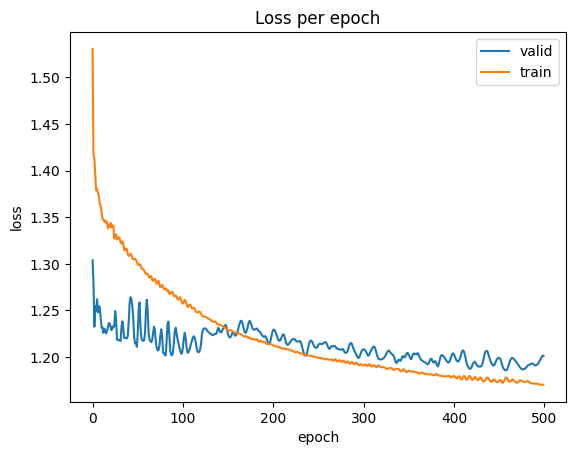

In [11]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

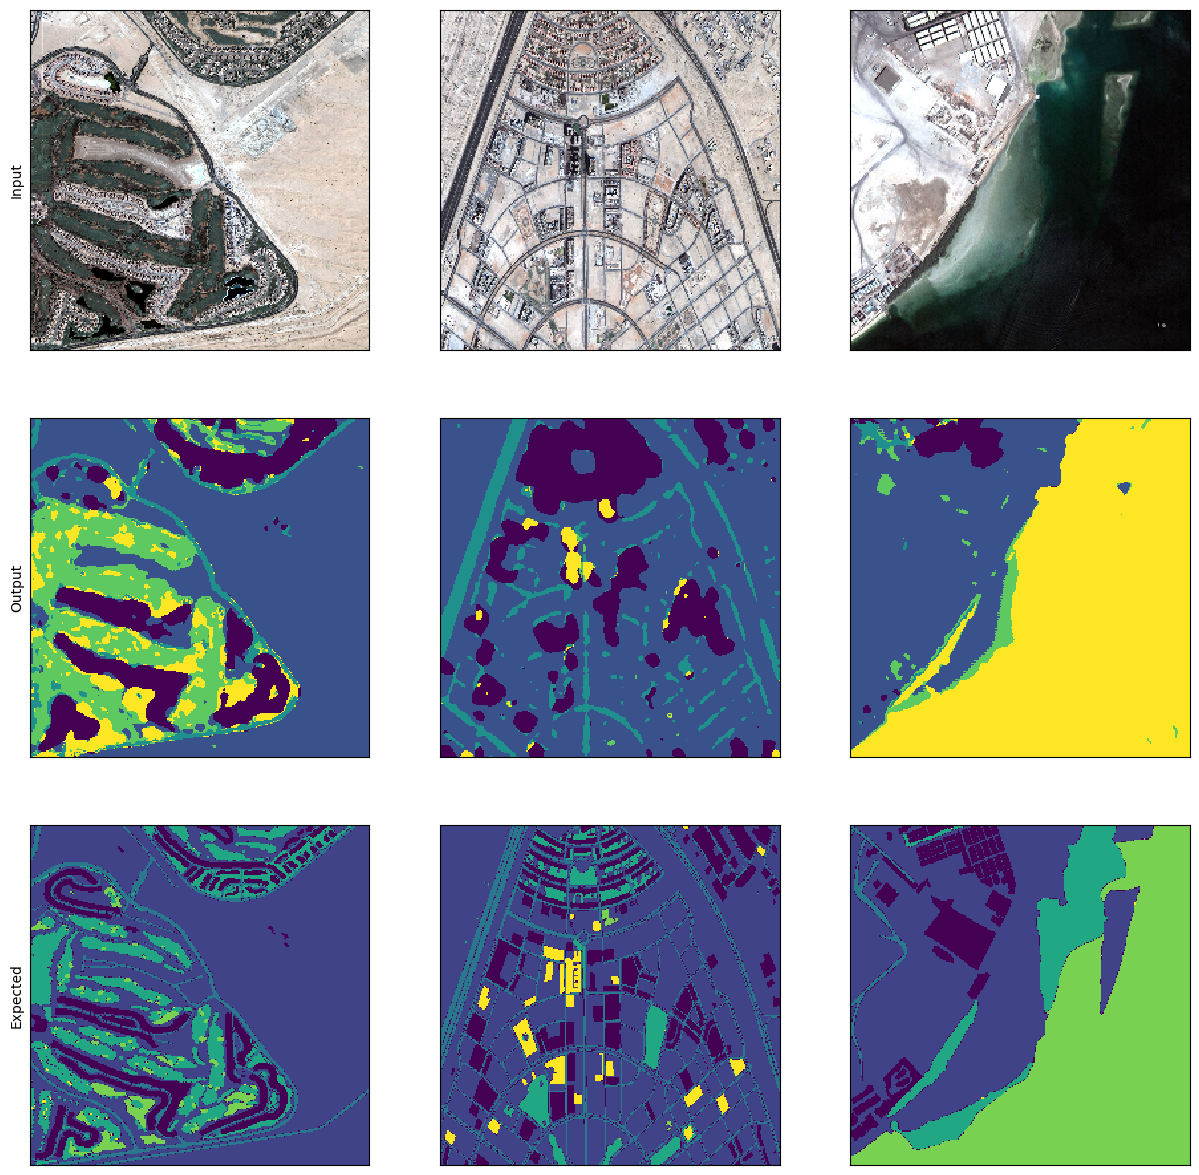

In [12]:
w = 3
fig, ax = plt.subplots(3, w, figsize=(15, 15))

ax[0][0].set_ylabel("Input")
ax[1][0].set_ylabel("Output")
ax[2][0].set_ylabel("Expected")
with torch.no_grad():
    for j in range(w):
        instances, targets = next(iter(test_loader))
        ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
        ax[0][j].set_xticks([])
        ax[0][j].set_yticks([])

        ax[1][j].imshow(torch.argmax(best_model(instances[0].to(device).unsqueeze(0)).squeeze(0).permute(1, 2, 0), dim=2).cpu().numpy().astype("uint8"), interpolation="None")
        ax[1][j].set_xticks([])
        ax[1][j].set_yticks([])

        ax[2][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
        ax[2][j].set_xticks([])
        ax[2][j].set_yticks([])

In [13]:
from utils.evaluation.multi_channel_iou import IoU
iou = IoU().to(device)

In [14]:
iou_test = torch.zeros([1, 7]).to(device)

for instances, targets in test_loader:
    predict = torch.zeros(targets.shape).to(device)
    res = torch.argmax(best_model(instances.to(device)), dim=-3)
    for ch in range(targets.shape[1]):
        predict[:, ch, :, :] = (res == ch)
    iou_test += iou(predict, targets.to(device))

iou_test /= len(test_loader)
iou_test

tensor([[0.2655, 0.2067, 0.6022, 0.1582, 0.0782, 0.4046, 0.1429]],
       device='cuda:0')

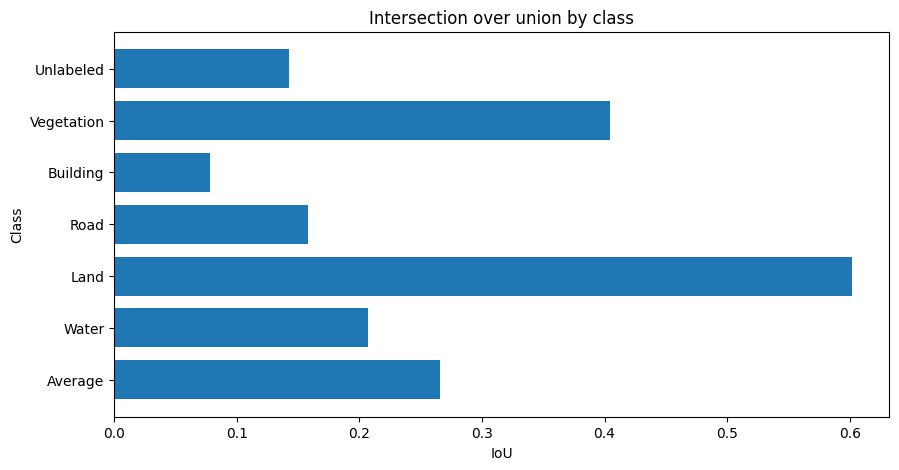

In [15]:
classes = ["Average", "Water", "Land", "Road", "Building", "Vegetation", "Unlabeled"]
values = list(iou_test.squeeze().cpu().numpy())

fig = plt.figure(figsize = (10, 5))

plt.barh(classes, values, height=0.75)
 
plt.xlabel("IoU")
plt.ylabel("Class")
plt.title("Intersection over union by class")
plt.show()

In [17]:
to_save = True

if to_save:
    torch.save(best_model.state_dict(), r"model\weights\best_deconv_sun.zip")